In [43]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import xgboost as xgb
import seaborn as sns


pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)

In [25]:
data = pd.read_parquet("../data_users/results_multiple_days_full.parquet")

data["SuperUser"] = data["SuperUser"].astype(int)
data["AboutMe_Present"] = data["AboutMe_Present"].astype(int)
data["Location_Present"] = data["Location_Present"].astype(int)
data["WebsiteUrl_Present"] = data["WebsiteUrl_Present"].astype(int)

print(data.shape)
print(data.columns)
print(data.head())

(47565065, 10)
Index(['UserId', 'SuperUser', 'DaysSinceRegistration', 'AboutMe_Present', 'Location_Present', 'WebsiteUrl_Present', 'Answer_Count', 'Badge_Count', 'Comment_Count', 'Question_Count'], dtype='object')
   UserId  SuperUser  DaysSinceRegistration  AboutMe_Present  Location_Present  WebsiteUrl_Present  Answer_Count  Badge_Count  Comment_Count  Question_Count
0       1          1                      7                1                 1                   1           4.0          0.0            0.0             2.0
1       5          1                      7                1                 1                   1           5.0          0.0            2.0             1.0
2       9          1                      7                1                 1                   0           3.0          0.0            0.0             2.0
3      13          1                      7                1                 1                   1          10.0          0.0            1.0             2.0
4

In [28]:
# Index(['UserId', 'SuperUser', 'DaysSinceRegistration', 'Answer_Count', 'Badge_Count', 'Comment_Count', 'Question_Count'], dtype='object')

Xs_small = {}
ys_small = {}

Xs_full = {}
ys_full = {}

for day in tqdm(data["DaysSinceRegistration"].unique()):
    Xs_small[day] = data[data["DaysSinceRegistration"] == day][
        ["Answer_Count", "Badge_Count", "Comment_Count", "Question_Count"]
    ]
    ys_small[day] = data[data["DaysSinceRegistration"] == day]["SuperUser"]

    Xs_full[day] = data[data["DaysSinceRegistration"] == day][
        [
            "Answer_Count",
            "Badge_Count",
            "Comment_Count",
            "Question_Count",
            "AboutMe_Present",
            "Location_Present",
            "WebsiteUrl_Present",
        ]
    ]
    ys_full[day] = data[data["DaysSinceRegistration"] == day]["SuperUser"]

  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
log_preds_small = {}
log_preds_full = {}
log_models_small = {}
log_models_full = {}

# for each DaysSinceRegistration, train a logistic regression model
# and in log_preds, add a np array of pred vs actual
for day in tqdm(data["DaysSinceRegistration"].unique()):
    X = Xs_small[day]
    y = ys_small[day]
    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    preds = log_reg.predict(X)
    log_preds_small[day] = np.array([preds, y])
    log_models_small[day] = log_reg

    X = Xs_full[day]
    y = ys_full[day]
    log_reg = LogisticRegression()
    log_reg.fit(X, y)
    preds = log_reg.predict(X)
    log_preds_full[day] = np.array([preds, y])
    log_models_full[day] = log_reg

  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
xgb_preds_small = {}
xgb_preds_full = {}
xgb_models_small = {}
xgb_models_full = {}

for day in tqdm(data["DaysSinceRegistration"].unique()):
    X = Xs_small[day]
    y = ys_small[day]
    xgb_reg = xgb.XGBClassifier()
    xgb_reg.fit(X, y)
    preds = xgb_reg.predict(X)
    xgb_preds_small[day] = np.array([preds, y])
    xgb_models_small[day] = xgb_reg

    X = Xs_full[day]
    y = ys_full[day]
    xgb_reg = xgb.XGBClassifier()
    xgb_reg.fit(X, y)
    preds = xgb_reg.predict(X)
    xgb_preds_full[day] = np.array([preds, y])
    xgb_models_full[day] = xgb_reg

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
# plotting balanced accuracy for both models across DaysSinceRegistration
log_balanced_acc_small = []
xgb_balanced_acc_small = []
log_balanced_acc_full = []
xgb_balanced_acc_full = []

for day in tqdm(data["DaysSinceRegistration"].unique()):
    log_preds_day = log_preds_small[day]
    xgb_preds_day = xgb_preds_small[day]
    log_balanced_acc_small.append(balanced_accuracy_score(log_preds_day[1], log_preds_day[0]))
    xgb_balanced_acc_small.append(balanced_accuracy_score(xgb_preds_day[1], xgb_preds_day[0]))

    log_preds_day = log_preds_full[day]
    xgb_preds_day = xgb_preds_full[day]
    log_balanced_acc_full.append(balanced_accuracy_score(log_preds_day[1], log_preds_day[0]))
    xgb_balanced_acc_full.append(balanced_accuracy_score(xgb_preds_day[1], xgb_preds_day[0]))

  0%|          | 0/50 [00:00<?, ?it/s]

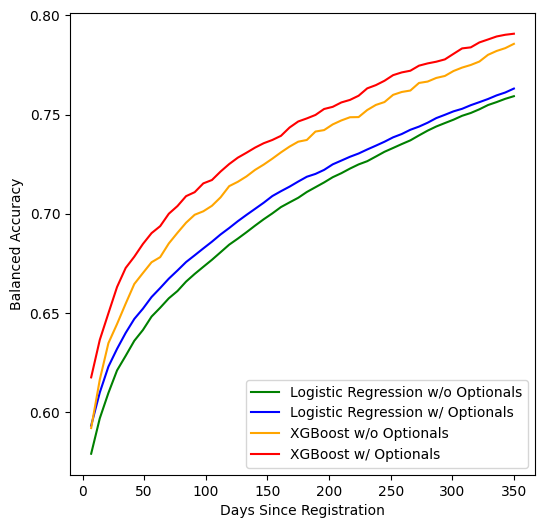

In [39]:
plt.figure(figsize=(6, 6))

plt.plot(
    data["DaysSinceRegistration"].unique(),
    log_balanced_acc_small,
    label="Logistic Regression w/o Optionals",
    color="green",
)
plt.plot(
    data["DaysSinceRegistration"].unique(),
    log_balanced_acc_full,
    label="Logistic Regression w/ Optionals",
    color="blue",
)
plt.plot(
    data["DaysSinceRegistration"].unique(),
    xgb_balanced_acc_small,
    label="XGBoost w/o Optionals",
    color="orange",
)
plt.plot(
    data["DaysSinceRegistration"].unique(),
    xgb_balanced_acc_full,
    label="XGBoost w/ Optionals",
    color="red",
)

plt.xlabel("Days Since Registration")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

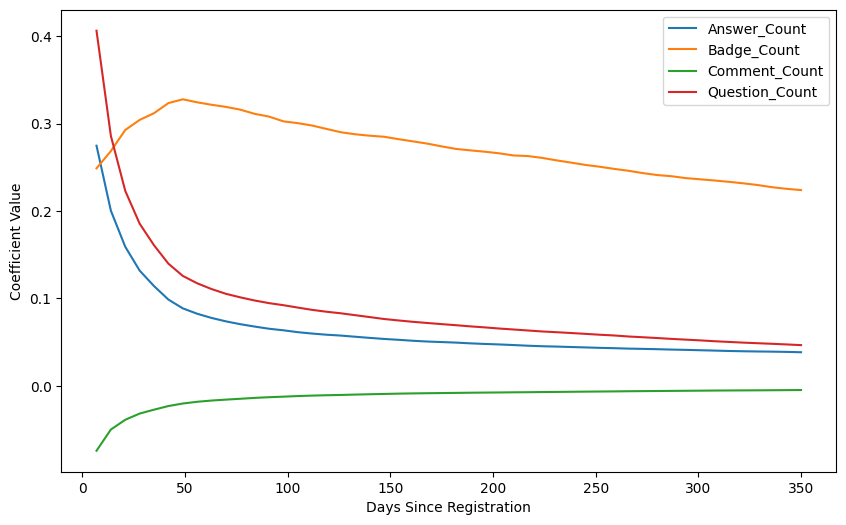

In [41]:
# plotting the log_reg coefficients across DaysSinceRegistration

# small first
log_reg_coef_small = []
for day in tqdm(data["DaysSinceRegistration"].unique()):
    log_reg_coef_small.append(log_models_small[day].coef_[0])

log_reg_coef_small = np.array(log_reg_coef_small)

first_key = next(iter(Xs_small))
column_names = Xs_small[first_key].columns

# Plot the coefficients
plt.figure(figsize=(10, 6))
for i in range(log_reg_coef_small.shape[1]):
    plt.plot(
        data["DaysSinceRegistration"].unique(),
        log_reg_coef_small[:, i],
        label=column_names[i]
    )

plt.xlabel("Days Since Registration")
plt.ylabel("Coefficient Value")
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

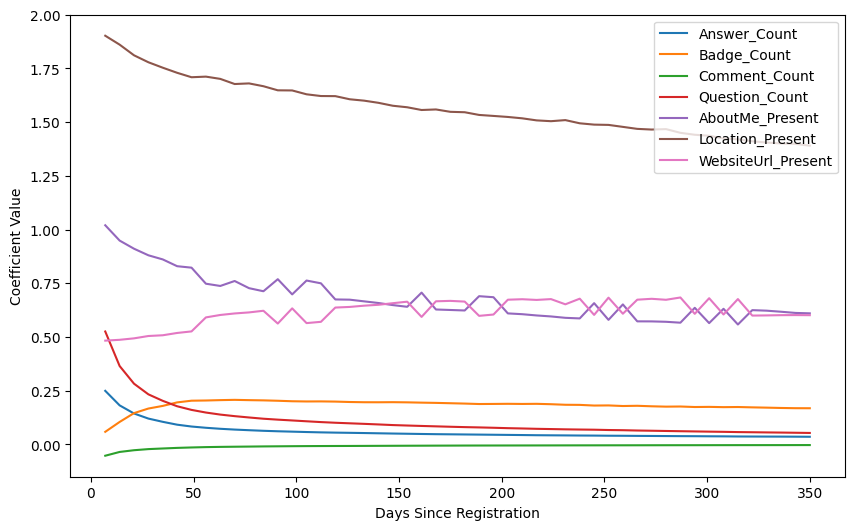

In [42]:
# full next
log_reg_coef_full = []
for day in tqdm(data["DaysSinceRegistration"].unique()):
    log_reg_coef_full.append(log_models_full[day].coef_[0])

log_reg_coef_full = np.array(log_reg_coef_full)

first_key = next(iter(Xs_full))
column_names = Xs_full[first_key].columns

# Plot the coefficients
plt.figure(figsize=(10, 6))
for i in range(log_reg_coef_full.shape[1]):
    plt.plot(
        data["DaysSinceRegistration"].unique(),
        log_reg_coef_full[:, i],
        label=column_names[i]
    )

plt.xlabel("Days Since Registration")
plt.ylabel("Coefficient Value")
plt.legend()
plt.show()

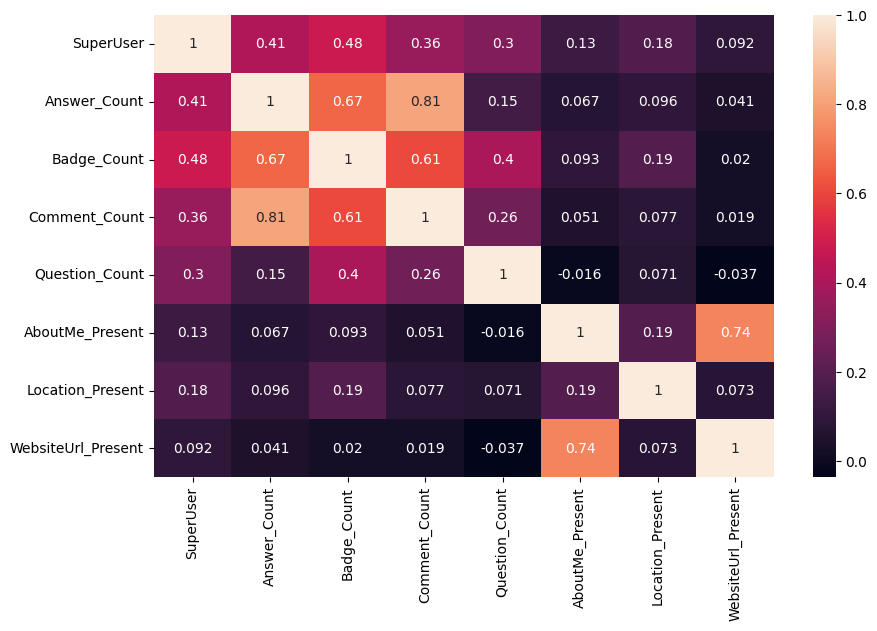

In [45]:
# finding correlation between the full featureset
corr = data[
    [
        "SuperUser",
        "Answer_Count",
        "Badge_Count",
        "Comment_Count",
        "Question_Count",
        "AboutMe_Present",
        "Location_Present",
        "WebsiteUrl_Present",
    ]
].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True)
plt.show()
